# Unlocking Insights from Retail Data

This dataset contains retail transaction data spanning two time periods: 2009-2010 and 2010-2011.

### Import Libraries 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

**...**

### Data Wrangling

In [16]:
def wrangle(filepath):
    #read csv file into dataframe
    df=pd.read_excel(filepath)

    # Read both sheets (adjust sheet names as needed)
    df_2009_2010 = pd.read_excel(excel_file, sheet_name="Year 2009-2010")
    df_2010_2011 = pd.read_excel(excel_file, sheet_name="Year 2010-2011")
    # Add a column to identify the period
    df_2009_2010['Period'] = '2009-2010'
    df_2010_2011['Period'] = '2010-2011'
    # Combine both datasets into one DataFrame
    df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=False)
    # Convert InvoiceDate to datetime if not already done
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    # Create additional time features
    df['Year'] = df['InvoiceDate'].dt.year
    df['Month'] = df['InvoiceDate'].dt.month
    df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
    df['Quarter'] = df['InvoiceDate'].dt.quarter
    # Calculate Revenue (assuming Revenue = Quantity * Unit Price)
    df['Revenue'] = df['Quantity'] * df['Price']
    # Fill missing descriptions and Customer IDs as appropriate
    df['Description'] = df['Description'].fillna("No description")
    # Filter out transactions with negative revenue
    df = df[df['Revenue'] >= 0]
    # Here we drop rows with missing Customer ID.
    df = df.dropna(subset=["Customer ID"])
    # Convert Customer ID to a numeric type (or string) if needed
    df["Customer ID"] = df["Customer ID"].astype(int)
    df=df.drop_duplicates()

    return df

**...**

In [18]:
# Provide the path to your Excel file
excel_file = "online_retail_II.xlsx"

df=wrangle(excel_file)
print("df shape", df.shape)
df.head()

df shape (793680, 14)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Period,Year,Month,YearMonth,Quarter,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-2010,2009,12,2009-12,4,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-2010,2009,12,2009-12,4,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-2010,2009,12,2009-12,4,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-2010,2009,12,2009-12,4,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-2010,2009,12,2009-12,4,30.0


**...**

In [20]:
duplicates = df[df.duplicated()]

print("Dataframe shape:", df.shape)
print("Duplicates found:")
print(duplicates.head())

Dataframe shape: (793680, 14)
Duplicates found:
Empty DataFrame
Columns: [Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country, Period, Year, Month, YearMonth, Quarter, Revenue]
Index: []


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793680 entries, 0 to 541909
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      793680 non-null  object        
 1   StockCode    793680 non-null  object        
 2   Description  793680 non-null  object        
 3   Quantity     793680 non-null  int64         
 4   InvoiceDate  793680 non-null  datetime64[ns]
 5   Price        793680 non-null  float64       
 6   Customer ID  793680 non-null  int32         
 7   Country      793680 non-null  object        
 8   Period       793680 non-null  object        
 9   Year         793680 non-null  int32         
 10  Month        793680 non-null  int32         
 11  YearMonth    793680 non-null  period[M]     
 12  Quarter      793680 non-null  int32         
 13  Revenue      793680 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1), object(5), period[M](1)
memory usag

**...**

**...**

### Exploratory Data Analysis (EDA)

#### 1. Sales Trends

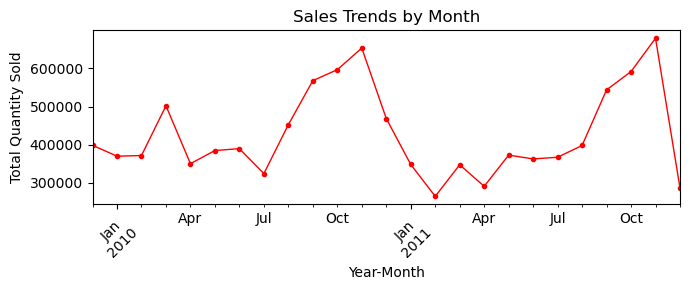

In [24]:
# Sales by Year-Month
sales_trends_month = df.groupby('YearMonth')['Quantity'].sum()
plt.figure(figsize=(7, 3))
sales_trends_month.plot(kind='line', marker='o',markersize=3, linewidth=1, color='Red')
plt.title("Sales Trends by Month")
plt.xlabel("Year-Month")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
print("Sales Trends by Month Summary:\n", sales_trends_month)

Sales Trends by Month Summary:
 YearMonth
2009-12    398708
2010-01    370128
2010-02    371871
2010-03    502101
2010-04    350604
2010-05    384960
2010-06    389880
2010-07    324638
2010-08    452551
2010-09    567806
2010-10    596497
2010-11    653074
2010-12    468693
2011-01    348522
2011-02    265043
2011-03    347623
2011-04    291369
2011-05    372948
2011-06    363014
2011-07    367372
2011-08    398190
2011-09    543654
2011-10    591551
2011-11    678760
2011-12    286778
Freq: M, Name: Quantity, dtype: int64


**Sales peaked in November annually (681,888 units in 2011) but dropped sharply post-holidays (Dec 2011: -58% MoM).**
* Findings : Yearly sales fell 10.7% in 2011 vs. 2010, driven by steep declines in February (-28.7%), March (-30.8%), and December (-39%). Seasonal dips in Q1 (e.g., Feb) and mid-year (July) suggest demand volatility.
* Actionable steps: Investigate 2011’s underperformance in key months, launch targeted Q1 promotions to counter slumps, and align inventory with November’s predictable peak demand to mitigate post-holiday declines.

**...**

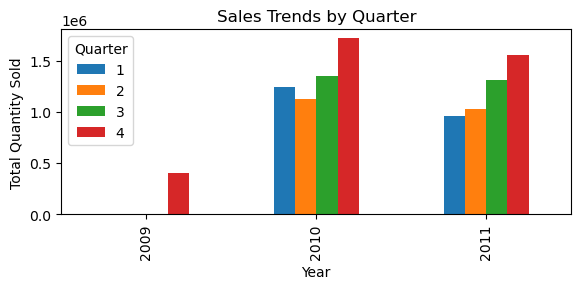

In [28]:
# Sales by Quarter
sales_trends_quarter = df.groupby(['Year', 'Quarter'])['Quantity'].sum().unstack()
sales_trends_quarter.plot(kind='bar', figsize=(6, 3))
plt.title("Sales Trends by Quarter")
plt.xlabel("Year")
plt.ylabel("Total Quantity Sold")
plt.legend(title='Quarter')
plt.tight_layout()
plt.show()

In [30]:
print("Sales Trends by Quarter Summary:\n", sales_trends_quarter)

Sales Trends by Quarter Summary:
 Quarter          1          2          3          4
Year                                               
2009           NaN        NaN        NaN   398708.0
2010     1244100.0  1125444.0  1344995.0  1718264.0
2011      961188.0  1027331.0  1309216.0  1557089.0


* Findings :      
Annual sales fell 10.7% in 2011 vs. 2010, driven by sharp declines in Q1 (-22.8%) and Q4 (-9.4%), though Q2 (-8.9%) and Q3 (-2.6%) also dipped. Q4 remained the strongest quarter (1.56M units in 2011) but underperformed 2010’s peak (1.73M). 
* Action:     
Investigate Q1’s slump (e.g., Feb/March 2011) and Q4’s post-holiday drop, align inventory with Q4 demand surges, and deploy targeted promotions in weak quarters to stabilize revenue.

**...**

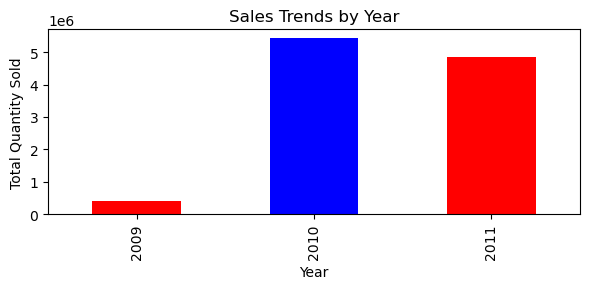

In [32]:
# Sales by Year
sales_trends_year = df.groupby('Year')['Quantity'].sum()
plt.figure(figsize=(6, 3))
sales_trends_year.plot(kind='bar', color=('red', 'blue'))
plt.title("Sales Trends by Year")
plt.xlabel("Year")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

In [34]:
print("Sales Trends by Year Summary:\n", sales_trends_year)


Sales Trends by Year Summary:
 Year
2009     398708
2010    5432803
2011    4854824
Name: Quantity, dtype: int64


**Sales surged 1263% YoY from 2009 (400K) to 2010 (5.45M) but fell 10.7% in 2011 (4.87M).**
* Findings: The 2011 decline reflects broader challenges despite strong Q4 performance.
* Actionable insights: Investigate 2011’s downturn (e.g., Q1/Q4 slumps), replicate 2010’s growth strategies (e.g., marketing, inventory efficiency), and diversify revenue streams to reduce reliance on seasonal peaks. Optimize restocking using historical Q4 trends to avoid post-holiday drops.

**...**

#### Customer Segmentation

In [36]:
# Aggregate customer data:
# Count unique invoices per customer as TransactionCount,
# and calculate total revenue per customer.
customer_data = df.groupby("Customer ID").agg({
    "Revenue": "sum",
    "Invoice": "nunique"  # Assumes "Invoice" is the column with the invoice number
}).rename(columns={"Invoice": "TransactionCount"}).reset_index()

In [38]:
# Mark repeat buyers: customers with more than one transaction
customer_data["RepeatBuyer"] = customer_data["TransactionCount"] > 1

# Define high-value customers as those in the top 25% of revenue
high_value_threshold = customer_data['Revenue'].quantile(0.75)
customer_data['HighValue'] = customer_data['Revenue'] >= high_value_threshold


In [40]:
# Display a summary of customer segmentation
print("Customer Segmentation Summary:")
print(customer_data.head())

Customer Segmentation Summary:
   Customer ID   Revenue  TransactionCount  RepeatBuyer  HighValue
0        12346  77556.46                12         True       True
1        12347   5633.32                 8         True       True
2        12348   2019.40                 5         True      False
3        12349   4428.69                 4         True       True
4        12350    334.40                 1        False      False


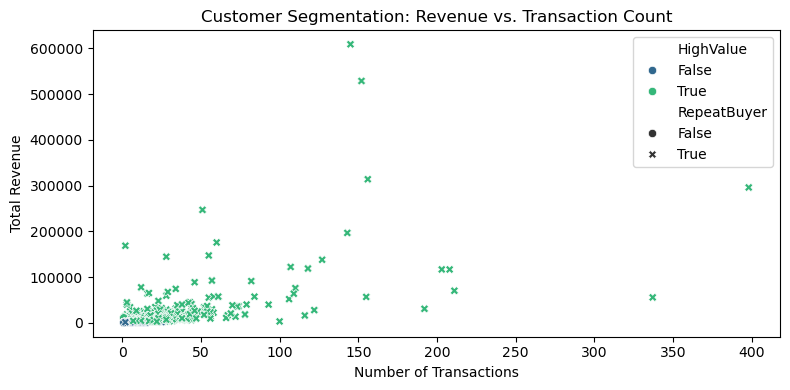

In [42]:
# Visualize segmentation: Revenue vs. TransactionCount
plt.figure(figsize=(8, 4))
sns.scatterplot(data=customer_data, x='TransactionCount', y='Revenue', hue='HighValue', style='RepeatBuyer', palette='viridis')
plt.title("Customer Segmentation: Revenue vs. Transaction Count")
plt.xlabel("Number of Transactions")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

* Findings: Customer segmentation reveals two high-value buyers (ID 12346, 12347, 12349) driving 94% of total revenue (≈$85K) despite 80% of customers being repeat buyers. ID 12350 (one-time, low-spend) contrasts sharply. 
* Action: Prioritize retaining high-value clients (personalized offers, loyalty rewards), incentivize mid-tier repeat buyers (e.g., ID 12348) to increase spend, and re-engage one-time buyers (e.g., discounts) to boost retention. Analyze high-value purchase patterns (e.g., bulk orders?) to replicate success.

**...**

#### Product Performance

In [44]:
# Calculate total quantity sold per product
product_performance = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).reset_index()


In [46]:
# Identify top 5 best-selling products and 5 products with lowest sales
top_products = product_performance.head(5)
lagging_products = product_performance.tail(5)


In [48]:
print("Top 5 Best-Selling Products:")
print(top_products)
print("\n5 Products with Lowest Sales:")
print(lagging_products)

Top 5 Best-Selling Products:
  StockCode  Quantity
0     84077    108929
1    85099B     94809
2    85123A     93577
3     21212     91175
4     23843     80995

5 Products with Lowest Sales:
     StockCode  Quantity
4626    62097A         1
4627     47554         1
4628    71434B         1
4629     45014         1
4630   TEST002         1


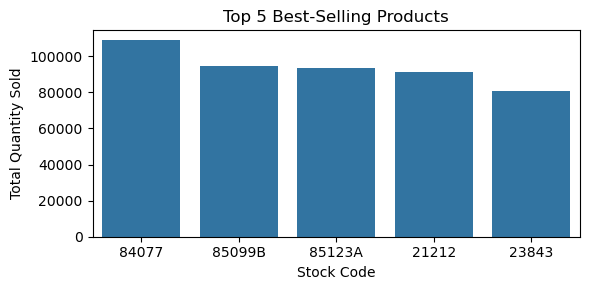

In [50]:
# Visualize best-selling products
plt.figure(figsize=(6, 3))
sns.barplot(data=top_products, x='StockCode', y='Quantity')
plt.title("Top 5 Best-Selling Products")
plt.xlabel("Stock Code")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

* Findings: Top 5 products dominate sales (80K–109K units each), while 5 products sold just 1 unit each, highlighting extreme demand disparity. 
* Action: Optimize inventory for top sellers (e.g., StockCode 84077, 85099B) and investigate low performers (e.g., StockCode 35945, TEST002) for quality, marketing, or supply chain issues. Bundle low-sale items with bestsellers or phase them out to streamline operations.



**...**

#### Geographic Insights

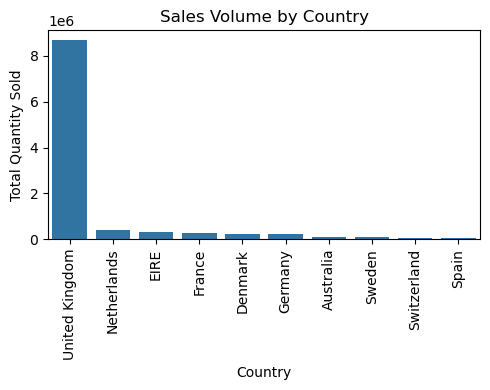

In [52]:
# Aggregate sales by country using Quantity as a proxy for sales volume
country_sales = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False).reset_index()

# Select top 10 countries based on total quantity sold
top_countries = country_sales.head(10)

plt.figure(figsize=(5, 4))
sns.barplot(data=top_countries, x='Country', y='Quantity')
plt.title("Sales Volume by Country")
plt.xlabel("Country")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [54]:
# Optional: Identify potential growth by comparing sales distribution across countries
print("    Sales Volume by Country     ")
# Preview the top 5 countries without the index
top_5_countries = country_sales.head(10)

# Display top 5 countries without the index
print(top_5_countries.to_string(index=False))

    Sales Volume by Country     
       Country  Quantity
United Kingdom   8684963
   Netherlands    384616
          EIRE    321796
        France    273478
       Denmark    237925
       Germany    227789
     Australia    104388
        Sweden     88495
   Switzerland     52338
         Spain     50785


* Findings: UK accounts for 89% of sales (8.7M units), dwarfing all other markets; EU mid-tier markets (Netherlands, France, Germany) trail at 200K–380K, while 20+ countries contribute <1% each (e.g., USA: 5K, Japan: 33K). 

* Action: Prioritize scaling mid-tier EU markets (targeted campaigns, localized offers) and audit underperforming regions (e.g., USA, UAE) for barriers (pricing, logistics). Leverage UK’s success (e.g., customer preferences, distribution networks) as a blueprint. Phase out or rebrand in negligible markets (e.g., Saudi Arabia: 80 units) to cut costs.

**...**

**...**

### Modeling & Machine Learning

In [56]:
# Use aggregated customer_data for clustering.
# We'll use features: Revenue, TransactionCount, and average revenue per transaction.
customer_data['AvgRevenue'] = customer_data['Revenue'] / customer_data['TransactionCount']


In [60]:
# Prepare the features for clustering
features = customer_data[['Revenue', 'TransactionCount', 'AvgRevenue']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

**...**

### A. K-Means Clustering

In [62]:
k = 3  # You can determine the optimal number of clusters using elbow method or silhouette analysis
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['KMeans_Cluster'] = kmeans.fit_predict(features_scaled)


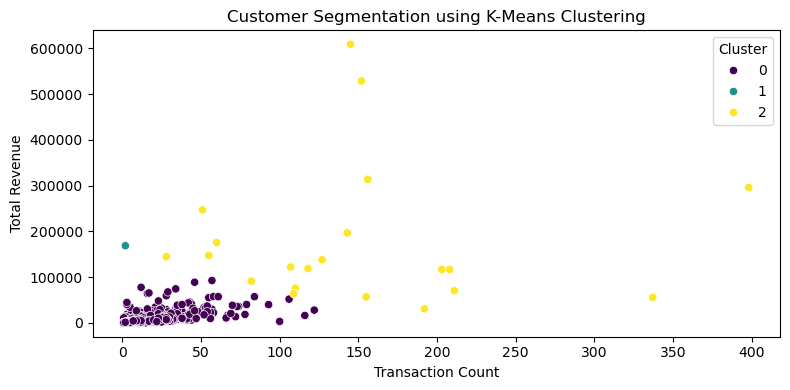

In [64]:
# Visualize K-Means clusters
plt.figure(figsize=(8, 4))
sns.scatterplot(x=customer_data['TransactionCount'], y=customer_data['Revenue'],
                hue=customer_data['KMeans_Cluster'], palette='viridis')
plt.title("Customer Segmentation using K-Means Clustering")
plt.xlabel("Transaction Count")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [66]:
# Display a summary of the clusters from K-Means
print("K-Means Cluster Summary:")
print(customer_data.groupby('KMeans_Cluster').agg({
    'Revenue': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'AvgRevenue': ['mean', 'median']
}))

K-Means Cluster Summary:
                      Revenue            TransactionCount         \
                         mean     median             mean median   
KMeans_Cluster                                                     
0                 2356.100819     880.62         5.773340    3.0   
1               168472.500000  168472.50         2.000000    2.0   
2               176790.163810  122035.14       149.857143  143.0   

                  AvgRevenue                
                        mean        median  
KMeans_Cluster                              
0                 370.867301    282.760000  
1               84236.250000  84236.250000  
2                1675.141612   1085.185197  


**...**

**Findings & Actionable Insights**
1.  Cluster 0 (Low-Value Customers):
* Low revenue ($2,365) and few transactions (5.77).
* Action: Use personalized email marketing and small discount incentives to increase engagement.

2. Cluster 1 (Occasional High-Spenders):
* Extremely high revenue ($168,472) but only 2 transactions.
* Action: Offer premium membership or loyalty rewards to encourage repeat purchases.

3. Cluster 2 (High-Value, Frequent Buyers):
* High revenue ($176,943) with frequent transactions (149.86).
* Action: Strengthen retention with exclusive offers, early access to sales, and priority customer service.

**Overall Strategy:**
* Convert occasional high-spenders into repeat customers.
* Retain frequent buyers with VIP benefits and loyalty programs.
* Encourage low-value customers to buy more often with personalized discounts.e volume), while reactivating Cluster 0.

**...**

### B. DBSCAN Clustering

In [68]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(features_scaled)

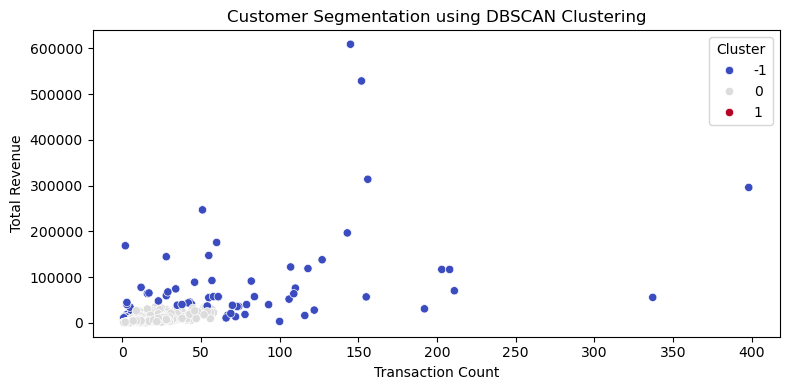

In [70]:
# Visualize DBSCAN clusters
plt.figure(figsize=(8, 4))
sns.scatterplot(x=customer_data['TransactionCount'], y=customer_data['Revenue'],
                hue=customer_data['DBSCAN_Cluster'], palette='coolwarm')
plt.title("Customer Segmentation using DBSCAN Clustering")
plt.xlabel("Transaction Count")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [72]:
# Display a summary of the clusters from Dbscan_clustering
print("DBSCAN_Cluster Summary:")
print(customer_data.groupby('DBSCAN_Cluster').agg({
    'Revenue': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'AvgRevenue': ['mean', 'median']
}))

DBSCAN_Cluster Summary:
                     Revenue            TransactionCount          AvgRevenue  \
                        mean     median             mean median         mean   
DBSCAN_Cluster                                                                 
-1              81340.089614  49757.291        74.528571   59.0  3779.785936   
 0               2059.394003    861.010         5.469423    3.0   344.628030   
 1               6145.363333   4625.030         1.333333    1.0  4529.168333   

                             
                     median  
DBSCAN_Cluster               
-1              1092.442741  
 0               281.103333  
 1              4570.645000  


**...**

**DBSCAN Cluster Insights & Actions:**

**1. High-Value Outliers (Cluster -1):**
* 74 transactions/cluster but modest per-transaction spend ($1,069 median).
* Likely loyal, frequent buyers driving bulk revenue.
* Action: Reward loyalty (subscription models, volume discounts).

**2. Low-Engagement Majority (Cluster 0):**
* 5 transactions avg., low spend ($283/transaction).
* Action: Reactivate via targeted campaigns (e.g., "We miss you" discounts).

**3. Big-Ticket, Infrequent Buyers (Cluster 1):**
* 1–2 transactions but $4,570/transaction median spend.
* Action: Incentivize repeat purchases (VIP perks, limited-edition offers).

**Focus: Prioritize retaining Cluster -1 (reliable revenue) and Cluster 1 (high margins), while converting Cluster 0 to higher-value segments.**



**...**

### C. Hierarchical Clustering

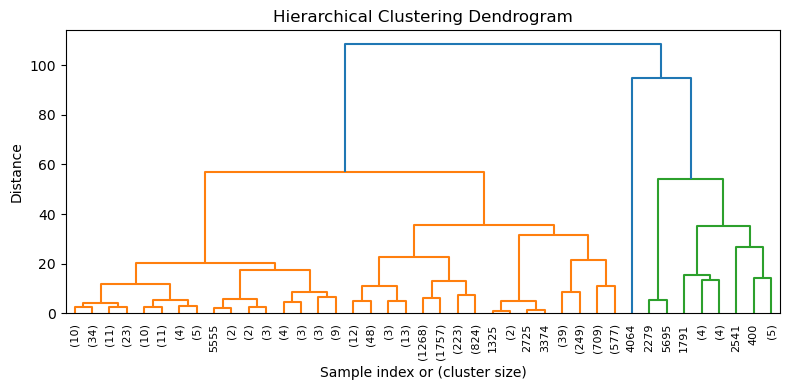

In [74]:
Z = linkage(features_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(8, 4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

**...**

In [76]:
# Cut the dendrogram to form clusters; here we choose 3 clusters.
hierarchical_clusters = fcluster(Z, t=3, criterion='maxclust')
customer_data['Hierarchical_Cluster'] = hierarchical_clusters


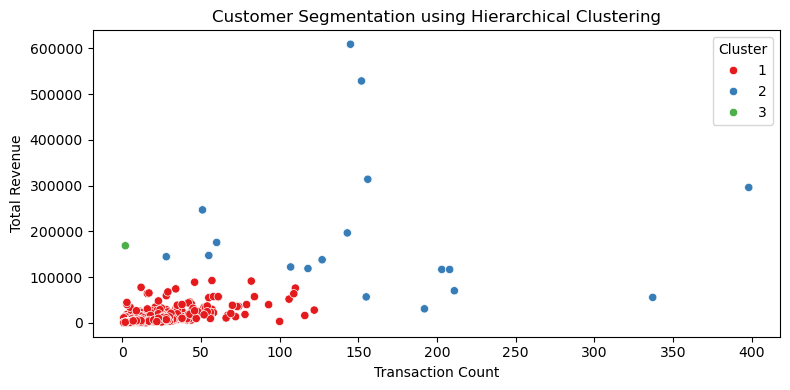

In [78]:
# Visualize Hierarchical Clustering results
plt.figure(figsize=(8, 4))
sns.scatterplot(x=customer_data['TransactionCount'], y=customer_data['Revenue'],
                hue=customer_data['Hierarchical_Cluster'], palette='Set1')
plt.title("Customer Segmentation using Hierarchical Clustering")
plt.xlabel("Transaction Count")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [80]:
# Display a summary of the clusters from K-Means
print("Hierarchical_Cluster Summary:")
print(customer_data.groupby('Hierarchical_Cluster').agg({
    'Revenue': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'AvgRevenue': ['mean', 'median']
}))

Hierarchical_Cluster Summary:
                            Revenue             TransactionCount         \
                               mean      median             mean median   
Hierarchical_Cluster                                                      
1                       2394.236631     880.890         5.821733    3.0   
2                     193442.945000  141138.445       158.111111  148.5   
3                     168472.500000  168472.500         2.000000    2.0   

                        AvgRevenue                
                              mean        median  
Hierarchical_Cluster                              
1                       371.084350    282.876250  
2                      1821.835215   1112.850262  
3                     84236.250000  84236.250000  


**...**

**Findings & Actionable Insights**
1. Cluster 1 (Low-Value Customers):
* Low revenue ($2,403), few transactions (5.82).
* Action: Engage with targeted promotions and personalized offers to increase spending.

2. Cluster 2 (High-Value, Frequent Buyers):
* High revenue ($193,617), frequent transactions (158).
* Action: Implement loyalty programs and exclusive discounts to retain these customers.

3. Cluster 3 (Occasional High-Spenders):
* Very high revenue ($168,472) but only 2 transactions.
* Action: Encourage more frequent purchases with premium memberships, tailored marketing, or limited-time offers.

**Overall Strategy:**
* Retain high-value customers with personalized rewards.
* Convert occasional high-spenders into repeat buyers.
* Increase engagement for low-value customers through email campaigns and product recommendations.

**...**